# Generating Metrics
Taking in our test data file and a corresponding prediction file and generating output metrics.



*   confusion matrix
*   f1, accuracy, precision, recall
*   AUC



## Imports and Constants

In [137]:
import itertools
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd

# all metrics functions take y_true, y_pred except for roc_auc_score, which takes y_true, y_score (probability of 1 label)
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc, roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix

In [138]:
TEST_FILE = "full_test.csv"
PRED_FILE = "ensemble_preds.csv"
SCORE_FILE = "ensemble_scores.csv"
GPT_PRED_FILE = "gpt_preds.csv"

In [139]:
N_TEST_FOR_ENSEMBLE = 500 # the number of test cases used to create the ensemble predictions

## Mounting Google Drive

In [140]:
GOOGLE_DRIVE_MOUNT_PATH_PREFIX = '/content/drive'
MY_CS152_DATA_FILE_PATH = "drive/MyDrive/Senior/SenSpr/CS152/CS152 Group Project/Milestone 3/Code/Data/" # NOTE: you have to modify this to fit wherever the CS152 Group Project/Milestone 3/Code/Data is in your Google Drive

In [141]:
from google.colab import drive
drive.mount(GOOGLE_DRIVE_MOUNT_PATH_PREFIX)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
cd $MY_CS152_DATA_FILE_PATH

[Errno 2] No such file or directory: 'drive/MyDrive/Senior/SenSpr/CS152/CS152 Group Project/Milestone 3/Code/Data/'
/content/drive/MyDrive/Senior/SenSpr/CS152/CS152 Group Project/Milestone 3/Code/Data


## Loading input files

In [143]:
test_data = pd.read_csv(TEST_FILE)

# only keep the "label" column
test_labels = test_data[["label"]]

In [144]:
y_true = test_labels.copy()
y_true.replace({"real": 0, "fake": 1}, inplace=True)

In [145]:
print(y_true)

      label
0         0
1         0
2         1
3         1
4         1
...     ...
2128      0
2129      0
2130      1
2131      0
2132      0

[2133 rows x 1 columns]


In [146]:
preds = pd.read_csv(PRED_FILE, header = None)

In [147]:
y_pred = preds.copy()

In [148]:
y_score = None
try:
  y_score = pd.read_csv(SCORE_FILE, header = None)
except:
  pass

In [149]:
def rename_single_col(new_name, df):
  column_names = df.columns.tolist()

  df = df.rename(columns={column_names[0]: new_name})
  return df

In [150]:
gpt_preds = pd.read_csv(GPT_PRED_FILE, header = None)
gpt_preds = rename_single_col("gpt", gpt_preds)

In [151]:
# filter out rows where gpt prediction wasn't available (because of org key auth block)
test_data = test_data[gpt_preds["gpt"] != -1] 
y_true = y_true[gpt_preds["gpt"] != -1] 
y_pred = y_pred[gpt_preds["gpt"] != -1]
y_score = y_score[gpt_preds["gpt"] != -1] 

In [152]:
print(len(test_data))
print(len(y_true))
print(len(y_pred))
print(len(y_score))

1996
1996
1996
1996


In [153]:
# filter out the test examples used to train the ensemble model
holdout_test_data = test_data.tail(len(test_data) - N_TEST_FOR_ENSEMBLE)
holdout_y_true = y_true.tail(len(y_true) - N_TEST_FOR_ENSEMBLE)
holdout_y_pred = y_pred.tail(len(y_pred) - N_TEST_FOR_ENSEMBLE)
holdout_y_score = y_score.tail(len(y_score) - N_TEST_FOR_ENSEMBLE)

## Helper Functions

In [154]:
# display accuracy, precision, recall, f1, roc_auc
def print_summary_statistics(y_true, y_pred, y_score = None):
  print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
  print(f"Precision: {precision_score(y_true, y_pred)}")
  print(f"Recall: {recall_score(y_true, y_pred)}")
  print(f"F1 Score: {f1_score(y_true, y_pred)}")

  if y_score:
    print(f"ROC AUC: {roc_auc_score(y_true, y_score)}")

In [166]:
def plot_roc_curve(y_true, y_score):
  if y_score is None:
    return
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Bert + GPT-3.5")
  display.plot()
  plt.title("ROC Curve")
  plt.show()

In [156]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

## Outputs

In [157]:
print_summary_statistics(holdout_y_true, holdout_y_pred)

Accuracy: 0.9725935828877005
Precision: 0.9785831960461285
Recall: 0.954983922829582
F1 Score: 0.9666395443449959


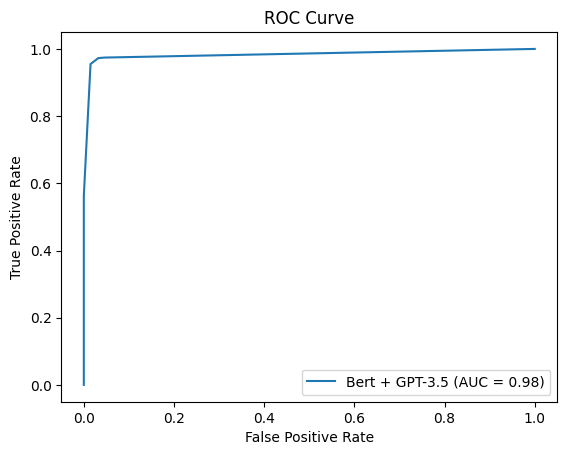

In [167]:
plot_roc_curve(holdout_y_true, holdout_y_score)

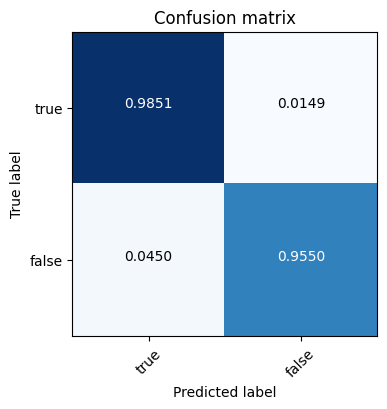

In [159]:
cm = confusion_matrix(holdout_y_true, holdout_y_pred)
plot_confusion_matrix(cm, target_names = ["true", "false"])

## [OPTIONAL] Get metrics on different datasets

### Constraint

In [160]:
constraint_y_true = holdout_y_true[test_data["dataset"] == "constraint"] 
constraint_y_pred = holdout_y_pred[test_data["dataset"] == "constraint"] 
constraint_y_score = holdout_y_score[test_data["dataset"] == "constraint"] 

<ipython-input-160-f33362b5e615>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constraint_y_true = holdout_y_true[test_data["dataset"] == "constraint"]
<ipython-input-160-f33362b5e615>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constraint_y_pred = holdout_y_pred[test_data["dataset"] == "constraint"]
<ipython-input-160-f33362b5e615>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constraint_y_score = holdout_y_score[test_data["dataset"] == "constraint"]


In [161]:
print(len(constraint_y_true))
print(len(constraint_y_pred))
print(len(constraint_y_score))

1212
1212
1212


In [162]:
print_summary_statistics(constraint_y_true, constraint_y_pred)

Accuracy: 0.9702970297029703
Precision: 0.9769911504424779
Recall: 0.96
F1 Score: 0.9684210526315788


### Checked

In [163]:
checked_y_true = holdout_y_true[test_data["dataset"] == "checked"] 
checked_y_pred = holdout_y_pred[test_data["dataset"] == "checked"] 
checked_y_score = holdout_y_score[test_data["dataset"] == "checked"] 

<ipython-input-163-bb8142d59751>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  checked_y_true = holdout_y_true[test_data["dataset"] == "checked"]
<ipython-input-163-bb8142d59751>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  checked_y_pred = holdout_y_pred[test_data["dataset"] == "checked"]
<ipython-input-163-bb8142d59751>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  checked_y_score = holdout_y_score[test_data["dataset"] == "checked"]


In [164]:
print(len(checked_y_true))
print(len(checked_y_pred))
print(len(checked_y_score))

284
284
284


In [165]:
print_summary_statistics(checked_y_true, checked_y_pred)

Accuracy: 0.9823943661971831
Precision: 1.0
Recall: 0.8936170212765957
F1 Score: 0.9438202247191011
